# WB-XIC, Lab3: Sieci neuronowe w praktyce

Bazując na [Dive into Deep Learning](https://d2l.ai/index.html) i [PyTorch](https://pytorch.org).

In [1]:
# pip install torch
import torch
import numpy as np
import matplotlib.pyplot as plt

#### Przykład 1. Klasyfikacja

Główna różnica w klasyfikacji to dodanie nowego wymiaru - klasy (np. `3` dla danych iris, `10` dla MNIST):
1. wektor `y` w klasyfikacji binarnej ma dwa wymiary `(N, 2)`
2. wektor `y_hat` po **feedforward** musi być normalizowany - prawdopodobieństwa przynależności do klas sumują się do 1 wykorzystując [SoftMax](https://d2l.ai/chapter_linear-networks/softmax-regression-concise.html#softmax-implementation-revisited)
3. stosujemy funkcję straty Cross entropy zamiast MSE; zmienia się sposób liczenia pochodnej

In [2]:
torch.manual_seed(1)
np.random.seed(1)

In [3]:
num_inputs = 4
X = np.random.normal(size=(1000, num_inputs))
y = X[:, 0] + X[:, 1] * X[:, 2]
y = (y > y.mean()).astype(int)
Y = np.column_stack((y, 1 - y))
num_outputs = Y.shape[1]
X = torch.as_tensor(X, dtype=torch.float32)
Y = torch.as_tensor(Y, dtype=torch.float32)

In [4]:
# requires_grad - informujemy o zaalokowaniu dodatkowej pamięci na gradient
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [5]:
(W, b)

(tensor([[ 0.0066,  0.0027],
         [ 0.0006,  0.0062],
         [-0.0045, -0.0017],
         [-0.0152,  0.0038]], requires_grad=True),
 tensor([0., 0.], requires_grad=True))

In [6]:
torch.mm(X, W)

tensor([[ 0.0291, -0.0027],
        [ 0.0080, -0.0178],
        [ 0.0267, -0.0110],
        ...,
        [ 0.0005,  0.0081],
        [ 0.0069,  0.0085],
        [-0.0179, -0.0068]], grad_fn=<MmBackward>)

In [7]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

In [8]:
def neural_network(X):
    # w tym przypadku architektura odpowiada regresji logistycznej
    return softmax(torch.mm(X.reshape((-1, W.shape[0])), W) + b)

In [9]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

In [10]:
neural_network(X)

tensor([[0.5079, 0.4921],
        [0.5065, 0.4935],
        [0.5094, 0.4906],
        ...,
        [0.4981, 0.5019],
        [0.4996, 0.5004],
        [0.4972, 0.5028]], grad_fn=<DivBackward0>)

In [11]:
np.abs((torch.as_tensor(y) - neural_network(X).argmax(1)).numpy()).mean() # error = 1 - accuracy

0.547

In [12]:
optimizer = torch.optim.SGD({W, b}, lr=0.01)
errors = []
losses = []
num_iter = 200

for i in range(num_iter):
    y_hat = neural_network(X)
    errors += [(torch.as_tensor(y) != y_hat.argmax(1)).float().mean().item()]
    l = cross_entropy(y_hat, y)
    optimizer.zero_grad()
    l.mean().backward()
    losses += [l.mean().item()]
    optimizer.step()

In [13]:
neural_network(X)

tensor([[0.2263, 0.7737],
        [0.3550, 0.6450],
        [0.4728, 0.5272],
        ...,
        [0.4921, 0.5079],
        [0.4926, 0.5074],
        [0.6982, 0.3018]], grad_fn=<DivBackward0>)

In [14]:
np.abs((torch.as_tensor(y) - y_hat.argmax(1)).numpy()).mean() # error = 1 - accuracy

0.189

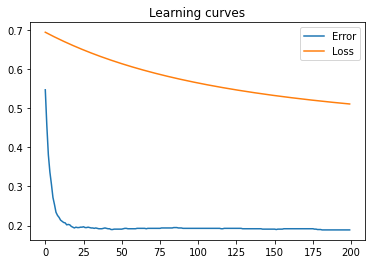

In [15]:
plt.plot(range(num_iter), errors)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error', 'Loss'])
plt.show()

In [16]:
neural_network(X)

tensor([[0.2263, 0.7737],
        [0.3550, 0.6450],
        [0.4728, 0.5272],
        ...,
        [0.4921, 0.5079],
        [0.4926, 0.5074],
        [0.6982, 0.3018]], grad_fn=<DivBackward0>)

In [17]:
(W, b)

(tensor([[-0.4079,  0.4172],
         [-0.0009,  0.0077],
         [-0.0021, -0.0041],
         [-0.0271,  0.0157]], requires_grad=True),
 tensor([ 0.0305, -0.0305], requires_grad=True))

## [Multilayer Perceptron (MLP)](https://d2l.ai/chapter_multilayer-perceptrons)

### Warstwy neuronów

![](fig/mlp.png)

In [18]:
import torch

X = torch.randn(size = (10, 4))
W1 = torch.randn(size = (4, 5))
b1 = torch.randn(size = (1, 5))
W2 = torch.randn(size = (5, 3))
b2 = torch.randn(size = (1, 3))
H = torch.mm(X, W1) + b1 
print(H)
O = torch.mm(H, W2) + b2
print(O)

tensor([[ 1.0411, -1.9455,  1.3863, -0.5666, -2.3573],
        [-0.6325,  1.6534, -0.2598, -2.5851,  2.0684],
        [ 0.5171,  0.2471, -1.3354, -4.1176,  3.1497],
        [ 0.1852, -0.2874,  0.5282, -2.2120,  0.2122],
        [ 2.6099, -0.3536, -2.9239, -3.2004,  2.7729],
        [ 0.5886, -1.4149, -0.3244, -1.1738,  0.6738],
        [ 0.3056, -0.7935, -0.0658, -2.9782,  1.2949],
        [ 0.6343, -2.8830, -1.6912, -0.5411,  2.4511],
        [ 1.2936, -0.7658, -1.7854, -2.1059,  2.2261],
        [-4.0256,  3.5153,  1.0562, -2.1962,  3.5030]])
tensor([[-3.1835, -4.8973, -4.1816],
        [ 3.6193,  3.8981,  0.3891],
        [ 3.7331,  1.7055, -0.6836],
        [ 0.9927, -0.3611, -1.7813],
        [-0.0788, -2.3975, -3.8806],
        [-0.9479, -1.1717, -0.9766],
        [ 1.8055, -0.0706, -1.0961],
        [-1.7902, -0.4942,  1.6725],
        [-0.0633, -0.7212, -1.4225],
        [ 8.2717, 12.2345,  6.9676]])


In [19]:
O_linear = torch.mm(X, torch.mm(W1, W2)) + torch.mm(b1, W2) + b2

In [20]:
O - O_linear

tensor([[ 0.0000e+00, -4.7684e-07,  4.7684e-07],
        [ 4.7684e-07, -4.7684e-07,  1.1921e-07],
        [ 9.5367e-07,  4.7684e-07,  1.1921e-07],
        [ 0.0000e+00, -5.9605e-08,  0.0000e+00],
        [ 1.1921e-07,  1.4305e-06, -2.3842e-07],
        [ 2.3842e-07, -2.3842e-07, -1.1921e-07],
        [ 4.7684e-07,  2.9802e-07,  1.1921e-07],
        [ 1.1921e-07,  7.1526e-07, -4.7684e-07],
        [-1.1921e-07,  1.1921e-07, -2.3842e-07],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])

In [21]:
(O - O_linear).abs().mean()

tensor(2.9008e-07)

### Funkcja aktywacji

![](fig/mlp-math.png)

In [22]:
X = torch.randn(size = (10, 4))
W1 = torch.randn(size = (4, 5))
b1 = torch.randn(size = (1, 5))
W2 = torch.randn(size = (5, 3))
b2 = torch.randn(size = (1, 3))
H = torch.sigmoid(torch.mm(X, W1) + b1) # https://pytorch.org/docs/stable/generated/torch.sigmoid
print(H)
O = torch.mm(H, W2) + b2
print(O)

tensor([[0.2501, 0.2580, 0.6765, 0.5183, 0.9387],
        [0.1933, 0.4328, 0.6829, 0.6611, 0.9551],
        [0.9779, 0.8343, 0.9973, 0.8885, 0.9290],
        [0.5943, 0.2581, 0.8514, 0.6509, 0.0660],
        [0.9988, 0.0702, 0.9992, 0.3348, 0.0716],
        [0.5158, 0.8592, 0.8361, 0.9107, 0.7777],
        [0.0269, 0.3977, 0.4472, 0.5402, 0.9997],
        [0.0168, 0.0226, 0.0127, 0.1404, 0.3521],
        [0.7220, 0.0348, 0.4125, 0.2072, 0.0358],
        [0.1298, 0.0694, 0.2196, 0.2697, 0.6851]])
tensor([[-1.4436,  0.9614,  0.5519],
        [-1.6547,  0.9310,  0.5924],
        [-2.7435,  2.1592, -0.0087],
        [-2.1297,  0.4871,  0.5716],
        [-2.0805,  1.0907,  0.3030],
        [-2.5462,  1.3536,  0.3878],
        [-1.4164,  0.8601,  0.5673],
        [-1.0735,  0.3518,  0.4423],
        [-1.7496,  0.9406,  0.1157],
        [-1.1128,  0.7347,  0.3901]])


In [23]:
(O - O_linear).abs().mean()

tensor(3.0275)

In [24]:
torch.nn.Softmax(dim=1)(O) # https://pytorch.org/docs/stable/generated/torch.nn.Softmax

tensor([[0.0515, 0.5700, 0.3785],
        [0.0421, 0.5592, 0.3986],
        [0.0066, 0.8914, 0.1020],
        [0.0338, 0.4627, 0.5035],
        [0.0280, 0.6681, 0.3039],
        [0.0145, 0.7138, 0.2717],
        [0.0555, 0.5409, 0.4036],
        [0.1030, 0.4282, 0.4688],
        [0.0451, 0.6639, 0.2910],
        [0.0845, 0.5359, 0.3797]])

#### Przykład 2. Klasyfikacja obrazu

Fashion-MNIST: [[GitHub](https://github.com/zalandoresearch/fashion-mnist)] [[PyTorch](https://pytorch.org/vision/stable/datasets.html#fashion-mnist)]

In [25]:
# pip install torchvision
import torchvision
import torch
import numpy as np


**Dane**

In [26]:
mnist_train = torchvision.datasets.FashionMNIST(
    root="/data", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root="/data", train=False, transform=torchvision.transforms.ToTensor(), download=True
)

In [27]:
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [28]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [29]:
examplary_dataloader_train = torch.utils.data.DataLoader(mnist_train, batch_size=1)
X, y = next(iter(examplary_dataloader_train))
{'image': X, 'class': y}

{'image': tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
            0.2863, 

**Model**

In [30]:
net = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 64), # 28^2
    torch.nn.ReLU(),
    torch.nn.Linear(64, 10)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=10, bias=True)
)

**Optymalizacja**

In [31]:
learning_rate = 0.05
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate) # Stochastic Gradient Descent

**Uczymy!**
\+ zapisujemy wyniki

In [32]:
num_iter = 10
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=2)
dataloader_test = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=2)

losses = []
errors_train = []
errors_test = []

# import tqdm # pip install tqdm
# for epoch in tqdm.tqdm(range(num_iter)):
for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    for X, y in dataloader_test:
        y_hat = net(X)
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for X, y in dataloader_train:
        y_hat = net(X)
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

**Pyt.** Czemu w 1 epoce błąd treningowy jest o wiele niższy niż testowy?

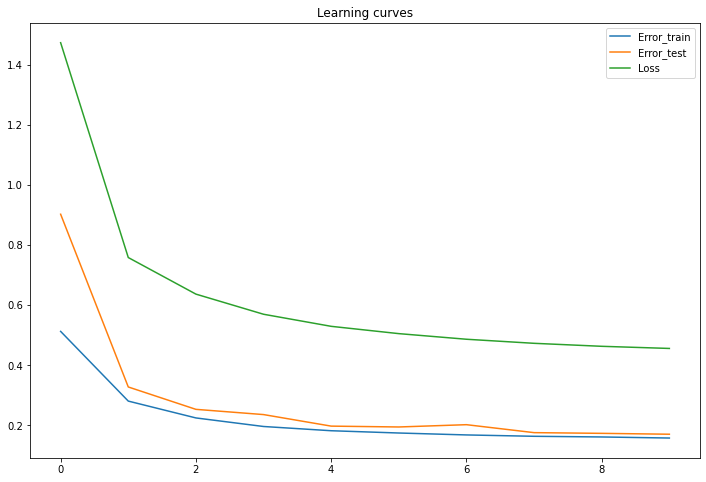

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.plot(range(num_iter), losses)
plt.title("Learning curves")
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

**Macierz konfuzji**

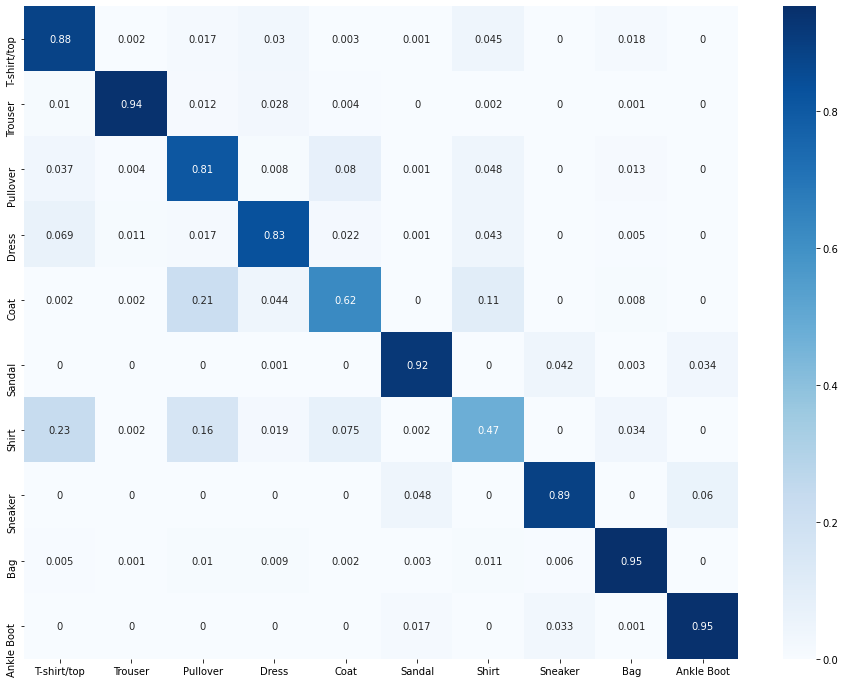

In [34]:
# https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloader_test:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (16, 12))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

### Przeuczenie i niedouczenie

- https://youtu.be/EuBBz3bI-aA?t=15

- https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

### Regularyzacja

![](fig/dropout.png)

#### Przykład 3. Walka z przeuczeniem

In [35]:
torch.manual_seed(1)
np.random.seed(1)

n_train = 1000
X_train = np.random.uniform(1, 3, size = (n_train, 5))
y_train = X_train[:, 2]**2 + X_train[:, 3]**3 + X_train[:, 4]**4

n_test = 1000
X_test = np.random.uniform(1, 3, size = (n_test, 5))
y_test = X_test[:, 2]**2 + X_test[:, 3]**3 + X_train[:, 4]**4 + np.random.normal(0, 6, size = n_test)

In [36]:
import plotly.express as px
px.scatter_3d(x=X_train[:, 2], y=X_train[:, 3], z=X_train[:, 4], color=y_train, color_discrete_map={True: "red", False: "blue"})

In [37]:
px.scatter_3d(x=X_test[:, 2], y=X_test[:, 3], z=X_test[:, 4], color=y_test, color_discrete_map={True: "red", False: "blue"})

In [38]:
X_train_t, X_test_t = torch.from_numpy(X_train).type(torch.float32), torch.from_numpy(X_test).type(torch.float32)
y_train_t, y_test_t = torch.from_numpy(y_train).type(torch.float32), torch.from_numpy(y_test).type(torch.float32)

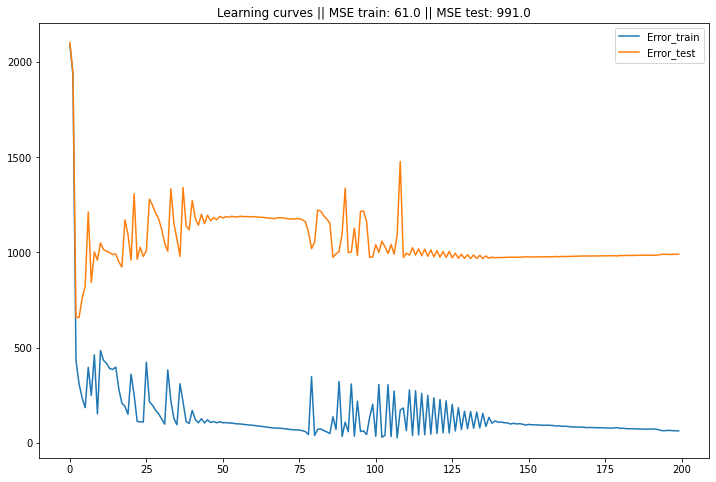

In [39]:
torch.manual_seed(1)
np.random.seed(1)

net = torch.nn.Sequential(
    torch.nn.Linear(5, 32),
    torch.nn.ReLU(),
    # torch.nn.Dropout(p=0.9),
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    # torch.nn.Dropout(p=0.9),
    torch.nn.Linear(32, 1)
)

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

learning_rate = 0.001
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

num_iter = 200
batch_size = 64

losses = []
errors_train = []
errors_test = []

for epoch in range(num_iter):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
    net.eval()
    for batch in range(int(X_train_t.shape[0] / batch_size)):
        X = X_train_t[batch*batch_size:((batch+1)*batch_size),]
        y = y_train_t[batch*batch_size:((batch+1)*batch_size),]
        y_hat = net(X)
        errors_train_iter += [torch.nn.functional.mse_loss(y, y_hat.flatten()).item()]

    for batch in range(int(X_test_t.shape[0] / batch_size)):
        X = X_test_t[batch*batch_size:((batch+1)*batch_size),]
        y = y_test_t[batch*batch_size:((batch+1)*batch_size),]
        y_hat = net(X)
        errors_test_iter += [torch.nn.functional.mse_loss(y, y_hat.flatten()).item()]

    net.train()
    for batch in range(int(X_train_t.shape[0] / batch_size)):
        X = X_train_t[batch*batch_size:((batch+1)*batch_size),]
        y = y_train_t[batch*batch_size:((batch+1)*batch_size),]
        y_hat = net(X)
        l = loss(y_hat.flatten(), y)
        optimizer.zero_grad()
        l.mean().backward()
        optimizer.step()
    
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]

plt.figure(figsize=(12, 8))
plt.plot(range(num_iter), errors_train)
plt.plot(range(num_iter), errors_test)
plt.title(f'Learning curves || MSE train: {errors_train[-1].round()} || MSE test: {errors_test[-1].round()}')
plt.legend(['Error_train', 'Error_test'])
plt.show()

## **Zagadnienia zaawansowane

### Inicjalizacja wag

- He; Xavier https://pytorch.org/docs/stable/nn.init

### Algorytmy optymalizacji

- Adam https://pytorch.org/docs/stable/generated/torch.optim.Adam

### Optymalizacja *learning rate*

- lr_scheduler https://pytorch.org/docs/stable/optim

### Przykłady naukowe
- 2012, AlexNet https://proceedings.neurips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html
- 2016, ResNet https://arxiv.org/abs/1512.03385
- 2017, DenseNet https://arxiv.org/abs/1608.06993
- 2021, EfficientNetV2 https://arxiv.org/abs/2104.00298


## Zadanie = Praca Domowa 1